# Introduction #

In this tutorial, we're going to build a simple deep learning model to solve crop classification task using satellite images. This notebook demonstrates the easy steps needed to be done in order to build a crop classification model starting from data preprocessing, model training, to making predictions.

## Crop Classification as a Machine Learning Problem ##

There are multiple ways to formulate the crop classification into a machine learning problem. However, the most commonly used one(especially when you use deep learning models) is to look at it as an image segmentation problem where you assign a class to each pixel of the image within the area of interest and each class represents a specific crop type as state in the problem statement.

### Data ###

The dataset you've received contains 2 formats of data: <i>raster</i> and <i>vector</i>.

#### Raster ####
Raster data is all the images taken from Sentinel-2 satellite in the period between Januaray 2020 to December 2021 over the study area. For each date, there are 10 images(.jp2) taken where each represents a wavelength of the signal that the satellite use the measure the earth surface(see the document we provide for detail explanation about each band). Data in these images is going to be used as the input of our ML model.

![Raster data](sample_raster.png)

#### Vector ####
Vector data contains information about farm boundaries which will help you to locate farms on the satellite image so that you can pick relevant region to extract features from them. Each farm in training data will have a `crop_type` column attach to it, this column indicates the type of plants that is grew in that farm so that you can use them to training and optimizing your ML model.

![Vector data](sample_vector.png)

To work with geospatial data in Python, there are 2 libraries that are very handy: [`rasterio`](https://rasterio.readthedocs.io/en/latest/index.html) and [`geopandas`](https://geopandas.org/en/stable/index.html). `Rasterio` provides functions to manipulate the satellite image files and vector data while `Geopandas` makes dealing with the ground data become much easier. The code below shows how you can use these 2 libraries to explore and manipulate the data.


Dataset profile : {'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': 0.0, 'width': 2051, 'height': 2051, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(10.0, 0.0, 754360.0,
       0.0, -10.0, 1688690.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


/Users/thanakorn/opt/anaconda3/envs/land-classification-dl-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


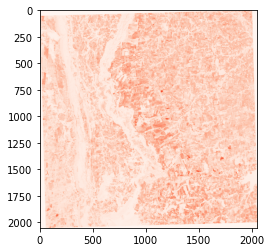

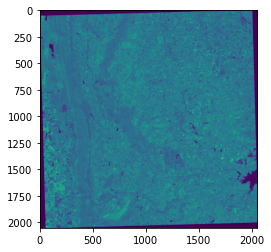

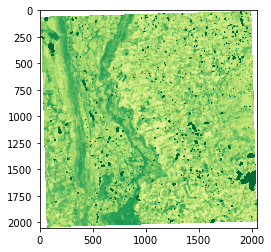

In [108]:
# Working with raster data
import rasterio
import matplotlib.pyplot as plt

# Open image files
R_dataset = rasterio.open('data/raw/image/20210101/IMG_DATA/47PQS_20210101_B04.jp2')
NIR_dataset = rasterio.open('data/raw/image/20210101/IMG_DATA/47PQS_20210101_B08.jp2')
print(f'Dataset profile : {R_dataset.profile}') # `profile` contains metadata about an image such as dimension, number of channels, and co-ordinate reference system 

# Read image data from dataset
R = R_dataset.read()[0]       # Read raster data from dataset, the array size will be equal to dimension in the dataset profile
NIR = NIR_dataset.read()[0]
NDVI = (NIR - R)/(NIR + R)  # Construct vegetation index(NDVI) by combining data from Red and Near-Infrared bands

plt.figure()
plt.imshow(R, cmap='Reds')
plt.figure()
plt.imshow(NIR)
plt.figure()
plt.imshow(NDVI, cmap='RdYlGn', vmin=-1, vmax=1)

  years crop_type                                           geometry
0  2021         1  POLYGON ((101.55476 15.10233, 101.55479 15.103...
1  2021         1  POLYGON ((101.54317 15.09377, 101.54337 15.094...
2  2021         1  POLYGON ((101.52758 15.12749, 101.52815 15.129...
3  2021         3  POLYGON ((101.52441 15.12918, 101.52553 15.129...
4  2021         2  POLYGON ((101.45462 15.16983, 101.45582 15.169...
           geometry
crop_type          
1               510
2               240
3               433
4               134


<AxesSubplot:>

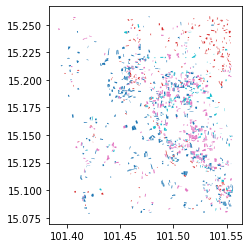

In [157]:
# Working with vector data
import geopandas

ground_truth = geopandas.read_file('data/raw/shape/training_area/train_data.shp')
print(ground_truth.head())                                                    # See sample data
print(ground_truth[['crop_type', 'geometry']].groupby(['crop_type']).count()) # Compute class distribution

# Visulize ground data
ground_truth.plot(column='crop_type')

## Pre-processing ##

Now that you have a basic understanding of data content and formats, we can proceed on preparing data for training the ML model.

In this tutorial, we're going to use Normalized Difference Vegetation Index([NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)) as a feature for classifying farm crop type. Here are the steps that we're going to do to prepare the train data:
1. Create monthly-NDVI image.
2. Convert ground truth data into the target image.
3. Split the monthly-NDVI image and the target image into patches.

### Create monthly-NDVI image ###

NDVI is the most widely used vegetation index in remote sensing as a measurement of plant health. In this example, we hypothesize that each crop type(rice, maize, casava, and sugarcane) has its own NDVI pattern. Therefore, we're going to compute NDVI of each month, stack them together, and use them as an input to the ML model.

Text(0.5, 1.0, 'MAY')

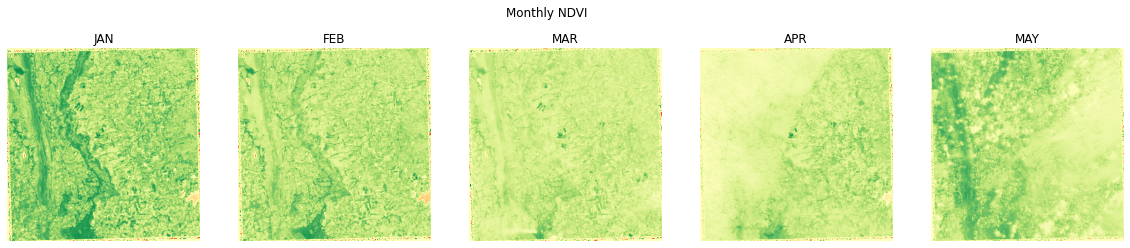

In [154]:
import numpy as np

# List of input files
file_templates = [
    'data/raw/image/20210101/IMG_DATA/47PQS_20210101_{0}.jp2',
    'data/raw/image/20210205/IMG_DATA/47PQS_20210205_{0}.jp2',
    'data/raw/image/20210302/IMG_DATA/47PQS_20210302_{0}.jp2',
    'data/raw/image/20210401/IMG_DATA/47PQS_20210401_{0}.jp2',
    'data/raw/image/20210501/IMG_DATA/47PQS_20210501_{0}.jp2',
]
ndvi_images = []

# Read B04 and B08 data, then construct NDVI image for each date
for template in file_templates:
    R = rasterio.open(template.format('B04')).read(1).astype(float)
    NIR = rasterio.open(template.format('B08')).read(1).astype(float)
    NDVI = np.divide(NIR - R, NIR + R, out=np.zeros_like(R), where=(NIR + R) != 0)
    ndvi_images.append(NDVI)

# Combine all NDVI images into a single multi-channel image where each channel represents NDVI of a specific month in ascending order
monthly_ndvi = np.stack(ndvi_images)

plt.figure(figsize=(20,4))
plt.suptitle('Monthly NDVI')
plt.subplot(151)
plt.imshow(monthly_ndvi[0], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.title('JAN')
plt.subplot(152)
plt.imshow(monthly_ndvi[1], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.title('FEB')
plt.subplot(153)
plt.imshow(monthly_ndvi[2], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.title('MAR')
plt.subplot(154)
plt.imshow(monthly_ndvi[3], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.title('APR')
plt.subplot(155)
plt.imshow(monthly_ndvi[4], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.title('MAY')

### Convert ground truth data into the target image. ##

After making the input image, we need the target image that we want the model to predict. The ground data, however, is in the vector format so it can't be used directly. Luckily, there is a way to convert vector data into image using `rasterio` and `geopandas`.